In [11]:
import hmac
import hashlib
import struct
import time
import unittest
import qrcode
import base64
import os
import secrets

**Implementación en Python de OATH HOTP + TOTP**

**Links usados:**

https://github.com/gingerlime/hotpie/blob/master/hotpie.py <br>
https://github.com/bdauvergne/python-oath/tree/master/oath <br>
https://sahandsaba.com/two-step-verification-using-python-pyotp-qrcode-flask-and-heroku.html <br>
https://github.com/google/google-authenticator/wiki/Key-Uri-Format <br>
https://docs.openstack.org/keystone/pike/advanced-topics/auth-totp.html <br>
https://github.com/pyauth/pyotp/blob/master/src/pyotp/otp.py

**Métodos**

In [2]:
def Truncate(hmac_digest):
    """
    Truncate representa la función que convierte un valor HMAC
    en un valor HOTP, como está definido en la Sección 5.3.
    http://tools.ietf.org/html/rfc4226#section-5.3
    """
    offset = int(hmac_digest[-1], 16)
    binary = int(hmac_digest[(offset * 2):((offset * 2) + 8)], 16) & 0x7fffffff
    return str(binary)

In [33]:
def HOTP(K, C, digits=6, digestmod=hashlib.sha1):
    """
    HOTP acepta la clave secreta K y el contador C
    opcionalmente se puede ajustar los digitos 
    
    Retorna el código entero OATH con longitud {digits} 
    """
    C_bytes = struct.pack(b"!Q", C) # Convierto el contador que es un entero a bytes
    hmac_digest = hmac.new(key=K, msg=C_bytes,
                           digestmod=digestmod).hexdigest()
    return Truncate(hmac_digest)[-digits:] # ak resultado devuelto por Truncate() lo trunco a la cantidad de digitos dado por digits.  

In [4]:
def TOTP(K, digits=6, window=30, clock=None, digestmod=hashlib.sha1):
    """
    TOTP es una variante de HOTP basada en el tiempo.
    Acepta solamente la clave secreta K, ya que el contador es derivado del timestamp actual
    opcionalmente se puede ajustar los dígitos
    opcionalmente se puede ajustar la ventana de tiempo

    retorna el código entero OATH con longitud {digits} 
    """
    if clock is None:
        clock = time.time()
    C = int(clock / window) # {T0 = 0}
    return HOTP(K, C, digits=digits, digestmod=digestmod)

**Claves Secretas**

https://emn178.github.io/online-tools/sha512.html

In [6]:
key_string = b'12345678901234567890' # 20 bytes
key_string_256 = b'12345678901234567890123456789012' # 32 bytes
key_string_512 = b'123456789012345678901234567890' + \
                      b'1234567890123456789012345678901234' # 64 bytes

**Secretos en BASE 32**

In [ ]:
secreto_SHA1_BASE_32 = "GI3DCYZVMFSDINJXG4YGGYZRGQ4DONLDHBTDINTFMFQTGZLDME2DENJWHAYTANDB"
secreto_SHA256_BASE_32 = "GJSTCODGMUYTKNLDGNSTMNTEGIZWKMJZG44TGZRSGA4TSNZYGI2GCNTBGZSWCMLFGNRTMODFMQ3DSNBVGMZWGOLCHE2DKMJTMVSWGMI="
secreto_SHA512_BASE_32 = "GVRWMNJYHEZDOYRUGEZTOODCMNRTANZWMIZDMYRTMI4DKMDBGY3GKYTDMVRTGYLDMU3TIZRWMI4TIOLEME2TIMBVG4ZDCZDEGM4TIOBYMEZDGODGGVQWMZTGG44TGYRVGEZDKMBTHBRGEMLEMQ3TCOBUMMYWGMJRMM2DOZRUHA2DIZBRMNRWEYRTGEYGGOLDG42TQOJTMI3DK==="

In [9]:
""" Seed for HMAC-SHA1 - 20 bytes """
seed = "3132333435363738393031323334353637383930"

""" Seed for HMAC-SHA256 - 32 bytes """ 
seed32 = "3132333435363738393031323334353637383930313233343536373839303132"

""" Seed for HMAC-SHA512 - 64 bytes """
seed64 = "31323334353637383930313233343536373839303132333435363738393031323334353637383930313233343536373839303132333435363738393031323334"

In [16]:
len(base64.b32decode("Y4NSKO4734TM4NADWAN2YEXIR74ZASDEN4EXQLKHNWC42MFV4H5Q===="))

32

**Probando HOTP**

In [2]:
hotp_result_vector = ['755224', '287082', '359152',
                      '969429', '338314', '254676',
                      '287922', '162583', '399871',
                      '520489','123456']

In [34]:
for i, r in enumerate(hotp_result_vector):
    print(HOTP(key_string, i))
    print(r)
    print("=====")

755224
755224
=====
287082
287082
=====
359152
359152
=====
969429
969429
=====
338314
338314
=====
254676
254676
=====
287922
287922
=====
162583
162583
=====
399871
399871
=====
520489
520489
=====
403154
123456
=====


**Probando TOTP**

In [30]:
totp_result_vector = [
            (key_string, 59, '94287082', hashlib.sha1),
            (key_string_256, 59, '46119246', hashlib.sha256),
            (key_string_512, 59, '90693936', hashlib.sha512),
            (key_string, 1111111109, '07081804', hashlib.sha1),
            (key_string_256, 1111111109, '68084774', hashlib.sha256),
            (key_string_512, 1111111109, '25091201', hashlib.sha512),
            (key_string, 1111111111, '14050471', hashlib.sha1),
            (key_string_256, 1111111111, '67062674', hashlib.sha256),
            (key_string_512, 1111111111, '99943326', hashlib.sha512),
            (key_string, 1234567890, '89005924', hashlib.sha1),
            (key_string_256, 1234567890, '91819424', hashlib.sha256),
            (key_string_512, 1234567890, '93441116', hashlib.sha512),
            (key_string, 2000000000, '69279037', hashlib.sha1),
            (key_string_256, 2000000000, '90698825', hashlib.sha256),
            (key_string_512, 2000000000, '38618901', hashlib.sha512),
            (key_string, 20000000000, '65353130', hashlib.sha1),
            (key_string_256, 20000000000, '77737706', hashlib.sha256),
            (key_string_512, 20000000000, '47863826', hashlib.sha512),
            (key_string_512, 3000000001, '47863826', hashlib.sha512),
        ]

In [31]:
for (key, clock, result, digestmod) in totp_result_vector:
    print(TOTP(key,digits=8,window=30,clock=clock,digestmod=digestmod))
    print(result)
    print("=======")

94287082
94287082
46119246
46119246
90693936
90693936
07081804
07081804
68084774
68084774
25091201
25091201
14050471
14050471
67062674
67062674
99943326
99943326
89005924
89005924
91819424
91819424
93441116
93441116
69279037
69279037
90698825
90698825
38618901
38618901
65353130
65353130
77737706
77737706
47863826
47863826
86564217
47863826


**Configuración de parámetros TOTP**

In [5]:
uri_totp = 'otpauth://{0}/{1}?{2}&{3}&{4}&{5}&{6}'

In [6]:
uri_totp = uri_totp.format('totp', 'alice@google.com', 'secret=31323334353637383930313233343536373839303132333435363738393031323334353637383930313233343536373839303132333435363738393031323334', 'issuer=alice', 'algorithm=SHA512', 'digits=8', 'period=60')
uri_totp

'otpauth://totp/alice@google.com?secret=IHGSY4B6SAZCYIN33QTBGRSPZBQJZLKR&issuer=alice&algorithm=SHA512&digits=8&period=60'

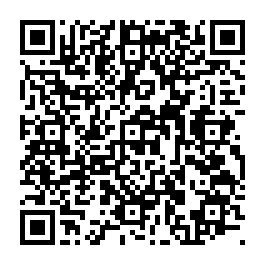

In [7]:
img = qrcode.make(uri_totp,box_size=5)
img

**Configuración de parámetros HOTP**

In [8]:
uri_hotp = 'otpauth://{0}/{1}?{2}&{3}&{4}&{5}&{6}'

In [9]:
uri_hotp = uri_hotp.format('hotp', 'lauren@google.com', 'secret=BBSWY3DPEHPK3PXP', 'issuer=lauren', 'algorithm=SHA256', 'digits=6', 'counter=10')
uri_hotp

'otpauth://hotp/lauren@google.com?secret=BBSWY3DPEHPK3PXP&issuer=lauren&algorithm=SHA256&digits=6&counter=10'

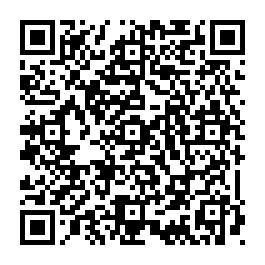

In [10]:
img = qrcode.make(uri_hotp,box_size=5)
img

**Implementación de HOTP y TOTP según pyotp**

https://github.com/pyauth/pyotp/blob/master/src/pyotp/otp.py <br>